In [2]:
import simpy
import random
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
import pandas as pd
import scipy.stats as stats 
from scipy.stats import shapiro 
from scipy.stats import f_oneway

In [3]:
def hyperexponential():
    """Generates random number between 0 and 1 from hyperexponential distribution"""
    while True:
        random_number = random.random()  
        if random_number < 0.75:
            # generate from exp with rate=1 with probability 0.75
            return random.expovariate(1)
        else:
            # generate from exp with rate=1/5 with probability 0.25
            return random.expovariate(1/5)

# Queue 

In [4]:
class queue:
    """A queue process. Generates a list with waiting times."""
    def __init__(self, env, arrival_rate, service_rate, num_servers, service_distribution):
        self.env = env
        self.server = simpy.Resource(env, num_servers)
        self.arrival_rate = arrival_rate
        self.service_rate = service_rate
        self.waiting_time_in_the_queue=[]
        self.service_distribution = service_distribution
        

    def arrival(self):
        """The arrival process generates customers according to a Poisson process"""
        while True:
            ### Interarrival times follow exponential
            next_customer= random.expovariate(self.arrival_rate)
            ### Wait for the customer
            yield self.env.timeout(next_customer)  
            
            ### Start a service process
            self.env.process(self.service())

    def service(self):
        """The service process. The customer arrives and requests a service. The service time is drawn from a 
           specified distribution"""
        with self.server.request() as req:
            queue_arrival_time= self.env.now
            yield req
            #### calculate waiting time
            waiting_time = self.env.now - queue_arrival_time
            
            if self.service_distribution == "exp":
                service_time = random.expovariate(self.service_rate)
            if self.service_distribution == "hyperexp":
                generated_number = hyperexponential()
                service_time = generated_number
            if self.service_distribution == "det":
                service_time = 1
            
            yield self.env.timeout(service_time)
            
            self.waiting_time_in_the_queue.append(waiting_time)

# Compute waiting time theoretically

In [5]:
def summation(n, rho):
    result = 0

    for i in range(n):
        S = (((n * rho) ** i) / math.factorial(i))
        result += S
        
    return result

def delay_probability(n, rho):
    pi = (((n * rho)**n)/math.factorial(n))*(1/(((1-rho)*summation(n, rho)) + ((n * rho) ** n)/ math.factorial(n)))
    return pi

def theory_waiting_time(n, rho, mu):
    W = delay_probability(n, rho)* (1/(1 - rho))*(1/n*mu)
    return W

rho_waiting_times = {}
rho_values = [0.4, 0.7, 0.9, 0.95]

waiting_time_list = []
for rho in rho_values:
    waiting_time_list.append(theory_waiting_time(1, rho, 1))
print(waiting_time_list)

[0.6666666666666667, 2.333333333333333, 9.000000000000002, 18.999999999999982]


# Simulate M/M/1 and plot mean waiting time and CI radius across the simulation duration

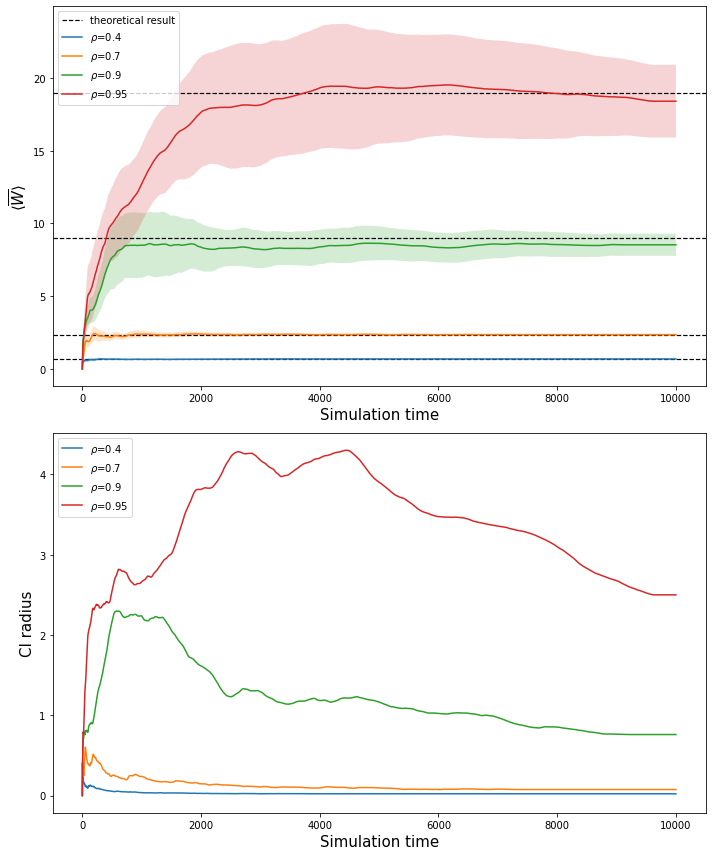

In [6]:
def setup_to_plot(arrival_rate, service_rate, sim_time, num_simulations, num_servers, service_distribution):
    """Setup, simulates and generates mean waiting time and its standard deviation"""
    all_means_waiting_time= []
    
    for i in range(num_simulations):
        
        env = simpy.Environment()
        my_queue = queue(env, arrival_rate, service_rate, num_servers, service_distribution)
        env.process(my_queue.arrival())
        env.run(until=sim_time)
        
        means = []  # collect means for one silmulation across sim_time
        
        for i in range(1, sim_time + 1):
            subset_data=my_queue.waiting_time_in_the_queue[:i]
            mean = np.mean(subset_data)
            means.append(mean)            
            
        all_means_waiting_time.append(means)

    return np.mean(all_means_waiting_time, axis=0), np.std(all_means_waiting_time, axis=0)

#parameters
simulation_time = 100000
num_servers= 1
num_simulations = 50
service_rate = 1   # keep service rate the same, but vary arrival rate to get range of rho values


### Plot for different rho values
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))
label_added = False 
for arrival_rate in [0.4, 0.7, 0.9, 0.95]:
    means, st_devs= setup_to_plot(arrival_rate, service_rate, simulation_time, num_simulations, num_servers, service_distribution ="exp")
    margin_error = [1.96 * i / np.sqrt(num_simulations) for i in st_devs]
    
    ### plot waiting time according to the theory 
    if not label_added:
        ax1.axhline(y=theory_waiting_time(num_servers, arrival_rate, service_rate), color='k', linestyle='--', linewidth=1.2, label='theoretical result')
        label_added = True  
    else:
        ax1.axhline(y=theory_waiting_time(1, arrival_rate, 1), color='k', linestyle='--', linewidth=1.2)
    ### plot mean waiting time according to the simulations
    ax1.plot(range(1, simulation_time +1), means, label=r'$\rho$=' + f'{arrival_rate}')
    ax1.fill_between(range(1, simulation_time +1), means+margin_error, means-margin_error, alpha=0.2)

    ### plot CI radius
    ax2.plot(range(1, simulation_time +1), margin_error, label=r'$\rho$=' + f'{arrival_rate}')

ax1.set_ylabel(r'$\langle \overline{W} \rangle$', fontsize=15)
ax1.set_xlabel("Simulation time", fontsize=15)
ax1.legend(loc='upper left', fontsize=10)
ax2.set_ylabel('CI radius', fontsize=15)
ax2.set_xlabel("Simulation time", fontsize=15)
ax2.legend(loc='upper left', fontsize=10)

plt.tight_layout()
ax1.figure.savefig('W_sim_time.png', dpi=300)
ax2.figure.savefig('CI_radius_sim_time.png', dpi=300)
plt.show()


# Chosen Parameters for all future simulations

In [7]:
simulation_time = 10000
num_simulations = 100
service_rate = 1

# Simulate M/M/n (n=1, 2, 4) and plot mean waiting time and CI radius for different rho values

Theoretical result

In [8]:
def theoretical_result_for_rhos(n):
    w_list = []
    for rho in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99]:
        w=theory_waiting_time(n, rho, 1)
        w_list.append(w)
    return w_list

Simulation

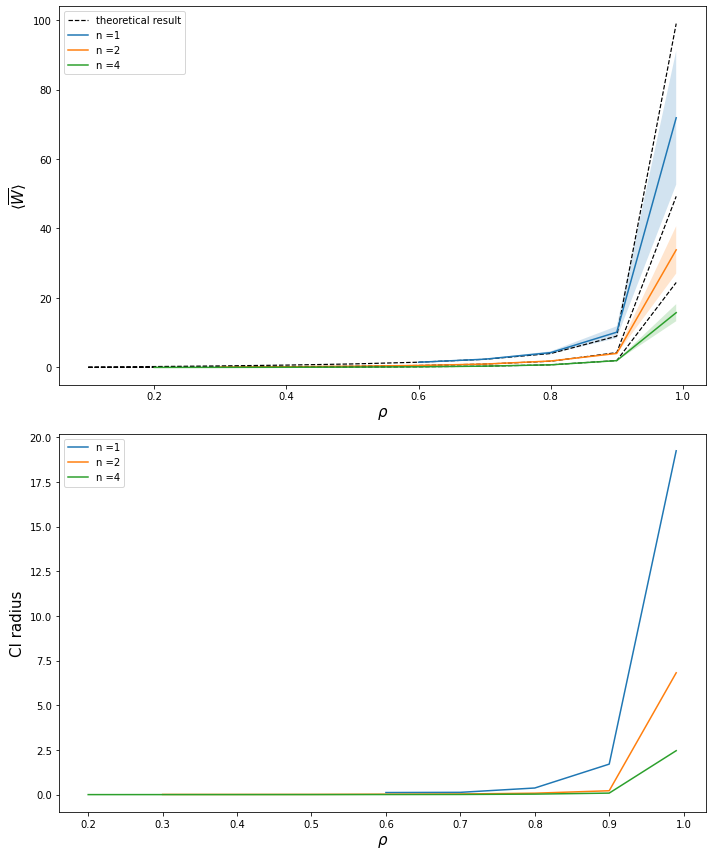

In [10]:
def setup_and_simulate(arrival_rate, service_rate, sim_time, num_simulations, num_servers, service_distribution):
    """Setup, simulates and returns mean waiting times from record =5000"""
    means = []  
    for i in range(num_simulations):

            env = simpy.Environment()
            my_queue = queue(env, arrival_rate, service_rate, num_servers, service_distribution)
            env.process(my_queue.arrival())
            env.run(until=sim_time)
            waiting_time = my_queue.waiting_time_in_the_queue[5000:]

            means.append(waiting_time)

    mean = [np.mean(lst, axis=0) for lst in means] 
    return mean
    

def different_rhos(service_rate, sim_time, num_simulations, num_servers, service_distribution, rho_list):
    """Simulate for different rho values and returns mean waiting times, mean sample waiting time 
       and its standart deviation"""
    wait_times= []
    
    for arrival_rate in rho_list:
        if num_servers==1:
            simulations = setup_and_simulate(arrival_rate, service_rate, sim_time, num_simulations, num_servers, service_distribution)
            wait_times.append(simulations)
        else:
            simulations = setup_and_simulate(arrival_rate*num_servers, service_rate, sim_time, num_simulations, num_servers, service_distribution)
            wait_times.append(simulations)
            
    mean_wait_times = [np.mean(lst, axis=0) for lst in wait_times] 
    std_dev_wait_times = [np.std(lst, axis=0) for lst in wait_times]
    entire_data = wait_times
    return entire_data, np.array(mean_wait_times), np.array(std_dev_wait_times)


### Plotting
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))
label_added = False 
for i in [1, 2, 4]:
    detailed_rho_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99]
    data, means, stdev = different_rhos(service_rate, simulation_time, num_simulations, i, service_distribution ="exp", rho_list =detailed_rho_list)
    margin_error = [1.96 * _ / np.sqrt(num_simulations) for _ in stdev]
    
    ### plot theoretical result
    if not label_added:
        ax1.plot(detailed_rho_list, theoretical_result_for_rhos(i), color='k', linestyle='--', linewidth=1.2, label= "theoretical result")
        label_added = True  
    else:
        ax1.plot(detailed_rho_list, theoretical_result_for_rhos(i), color='k', linestyle='--', linewidth=1.2)
        
    ### plot simulations
    ax1.plot(detailed_rho_list, means, label= r'n =' + f'{i}')
    ax1.fill_between(detailed_rho_list, means+margin_error, means-margin_error, alpha=0.2)
    
    ### plot CI radius
    ax2.plot(detailed_rho_list, margin_error, label= r'n =' + f'{i}')
    
ax1.set_ylabel(r'$\langle \overline{W} \rangle$', fontsize=15)
ax1.set_xlabel(r'$\rho$', fontsize=15)
ax1.legend(fontsize=10)
ax1.figure.savefig('W_rho.png', dpi=300)

ax2.set_ylabel("CI radius", fontsize=15)
ax2.set_xlabel(r'$\rho$', fontsize=15)
ax2.legend(fontsize=10)
ax2.figure.savefig('CI_radius_rho.png', dpi=300)

plt.tight_layout()
plt.show()
  

Plot sampling distribution of the sample mean

In [11]:
mm1_09 = different_rhos(service_rate , simulation_time, num_simulations, 1, service_distribution="exp", rho_list=[0.9, 0.99])
mm1_099 = different_rhos(service_rate , simulation_time, num_simulations, 1, service_distribution="exp", rho_list=[0.9, 0.99])

mm2_09 = different_rhos(service_rate , simulation_time, num_simulations, 2, service_distribution="exp", rho_list=[0.9, 0.99])
mm2_099 = different_rhos(service_rate , simulation_time, num_simulations, 2, service_distribution="exp", rho_list=[0.9, 0.99])

mm4_09 = different_rhos(service_rate , simulation_time, num_simulations, 4, service_distribution="exp", rho_list=[0.9, 0.99])
mm4_099 = different_rhos(service_rate , simulation_time, num_simulations, 4, service_distribution="exp", rho_list=[0.9, 0.99])

In [12]:
def normal_pdf(data):
    "Returns modelled x and PDF of the normal distribution from mean and st dev of the data"
    mean = np.mean(data)
    std_dev = np.std(data)
    # Define the range for x-values
    x = np.linspace(min(data), max(data), 1000)
    # Calculate the PDF of the normal distribution
    pdf = 1/(std_dev * np.sqrt(2 * np.pi)) * np.exp(-(x - mean)**2 / (2 * std_dev**2))
    return x, pdf

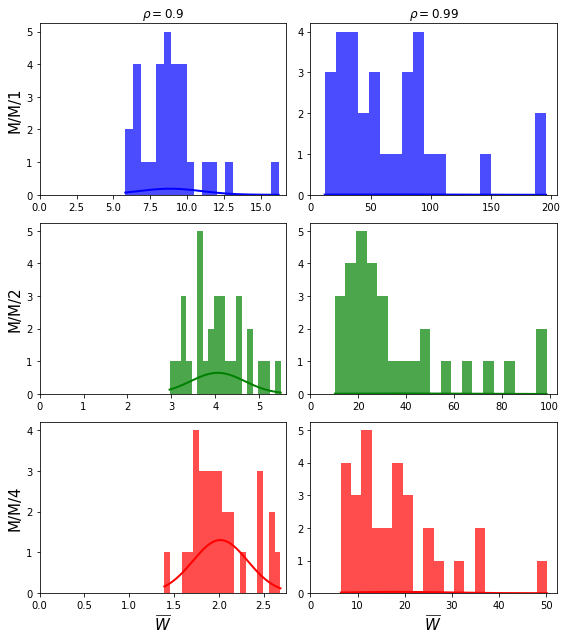

In [72]:
fig, axs = plt.subplots(3, 2, figsize=(8, 9))  
axs[0, 0].hist(mm1_09[0][0], bins=20, density=False, alpha=0.7, color='blue')
axs[0, 0].set_title(r'$\rho=0.9$')
axs[0, 0].plot(normal_pdf(mm1_09[0][0])[0], normal_pdf(mm1_09[0][0])[1], linewidth=2, color='blue')
axs[0, 0].set_xlim(left=0)

axs[0, 1].hist(mm1_099[0][1], bins=20, density=False, alpha=0.7, color='blue')
axs[0, 1].set_title(r'$\rho=0.99$')
axs[0, 1].plot(normal_pdf(mm1_099[0][1])[0], normal_pdf(mm1_099[0][1])[1], linewidth=2, color='blue')
axs[0, 1].set_xlim(left=0)

axs[1, 0].hist(mm2_09[0][0], bins=20, density=False, alpha=0.7, color='green')
axs[1, 0].plot(normal_pdf(mm2_09[0][0])[0], normal_pdf(mm2_09[0][0])[1], linewidth=2, color='green')
axs[1, 0].set_xlim(left=0)

axs[1, 1].hist(mm2_099[0][1], bins=20, density=False, alpha=0.7, color='green')
axs[1, 1].plot(normal_pdf(mm2_099[0][1])[0], normal_pdf(mm2_099[0][1])[1], linewidth=2, color='green')
axs[1, 1].set_xlim(left=0)

axs[2, 0].hist(mm4_09[0][0], bins=20, density=False, alpha=0.7, color='red')
axs[2, 0].plot(normal_pdf(mm4_09[0][0])[0], normal_pdf(mm4_09[0][0])[1], linewidth=2, color='red')
axs[2, 0].set_xlim(left=0)

axs[2, 1].hist(mm4_099[0][1], bins=20, density=False, alpha=0.7, color='red')
axs[2, 1].plot(normal_pdf(mm4_099[0][1])[0], normal_pdf(mm4_099[0][1])[1], linewidth=2, color='red')
axs[2, 1].set_xlim(left=0)

for ax in axs[-1, :]: 
    ax.set_xlabel(r'$\widebar{W}}$', fontsize=15)     
    
y_labels = ['M/M/1', 'M/M/2', 'M/M/4']  
for i, ax in enumerate(axs[:, 0]):  
    ax.set_ylabel(y_labels[i], fontsize=15) 
    
    ax.grid(False)
plt.tight_layout()
plt.savefig("sampling_distribution_MMn.png", dpi=300)
plt.show()

Statistical test for normality of the distributions

In [14]:
#perform Shapiro-Wilk test for normality for rho=0.9
print(shapiro(mm1_09[0][0]))
print(shapiro(mm2_09[0][0]))
print(shapiro(mm4_09[0][0]))

## if p<0.05 -- reject normality

ShapiroResult(statistic=0.8992737531661987, pvalue=0.008062398061156273)
ShapiroResult(statistic=0.979678213596344, pvalue=0.8169332146644592)
ShapiroResult(statistic=0.9430453181266785, pvalue=0.10987948626279831)


In [24]:
#perform Shapiro-Wilk test for normality for rho=0.99
print(shapiro(mm1_099[0][0]))
print(shapiro(mm2_099[0][0]))
print(shapiro(mm4_099[0][0]))

## if p<0.05 -- reject normality

ShapiroResult(statistic=0.8858560919761658, pvalue=0.0038533920887857676)
ShapiroResult(statistic=0.9103565216064453, pvalue=0.015191808342933655)
ShapiroResult(statistic=0.934461772441864, pvalue=0.06457890570163727)


Get statistics 

In [15]:
#means for rho=0.9
mean_mm1_09 = mm1_09[1][0]
mean_mm2_09 = mm2_09[1][0]
mean_mm4_09 = mm4_09[1][0]
print(mean_mm1_09, mean_mm2_09, mean_mm4_09)

#std dev for rho=0.9
std_mm1_09 = mm1_09[2][0]
std_mm2_09 = mm2_09[2][0]
std_mm4_09 = mm4_09[2][0]
print(std_mm1_09, std_mm2_09, std_mm4_09)

#CI radius for rho=0.9
mmn_margin_errors = [1.96 * i / np.sqrt(num_simulations) for i in [std_mm1_09, std_mm2_09, std_mm4_09]]
print(mmn_margin_errors)

8.83538940661391 4.053821367012249 2.0168461827320745
2.1379047804875895 0.6155009636285667 0.30642210908681095
[0.7650394003931731, 0.22025419113774805, 0.10965174349323464]


Perform statistical tests

In [30]:
### F-test for rho=0.9
alpha = 0.05

#MM1 vs MM2
f_statistic1, p_value1 = f_oneway(mm1_09[0][0], mm2_09[0][0])
print(p_value1)

#MM1 vs MM4
f_statistic2, p_value2 = f_oneway(mm1_09[0][0], mm4_09[0][0])
print(p_value2)
#MM2 vs MM4
f_statistic3, p_value3 = f_oneway(mm2_09[0][0], mm4_09[0][0])
print(p_value3)

# Compare p-value with alpha
if p_value2 < alpha:
    print("Reject null hypothesis: Variances are significantly different.")
else:
    print("Fail to reject null hypothesis: No significant difference in variances.")

1.0461817800729731e-16
3.347035444315929e-24
7.056132326779236e-23
Reject null hypothesis: Variances are significantly different.


In [31]:
#### Welch's t-test for rho=0.9

#MM1 vs MM2
print(stats.ttest_ind(mm1_09[0][0],mm2_09[0][0], equal_var = False)) 

#MM1 vs MM4
print(stats.ttest_ind(mm1_09[0][0],mm4_09[0][0], equal_var = False)) 

#MM2 vs MM4
print(stats.ttest_ind(mm2_09[0][0],mm4_09[0][0], equal_var = False)) 

Ttest_indResult(statistic=11.574163878733277, pvalue=2.667359462205345e-13)
Ttest_indResult(statistic=17.001474495162654, pvalue=5.2137207584289694e-17)
Ttest_indResult(statistic=15.95421440899949, pvalue=1.454693914172048e-19)


# Plot M/M/n, M/H/n, M/D/n

In [20]:
mh1_09 = different_rhos(service_rate , simulation_time, num_simulations, 1, service_distribution="hyperexp", rho_list=[0.9])

mh2_09 = different_rhos(service_rate , simulation_time, num_simulations, 2, service_distribution="hyperexp", rho_list=[0.9])

mh4_09 = different_rhos(service_rate , simulation_time, num_simulations, 4, service_distribution="hyperexp", rho_list=[0.9])


In [21]:
md1_09 = different_rhos(service_rate , simulation_time, num_simulations, 1, service_distribution="det", rho_list=[0.9])

md2_09 = different_rhos(service_rate , simulation_time, num_simulations, 2, service_distribution="det", rho_list=[0.9])

md4_09 = different_rhos(service_rate , simulation_time, num_simulations, 4, service_distribution="det", rho_list=[0.9])


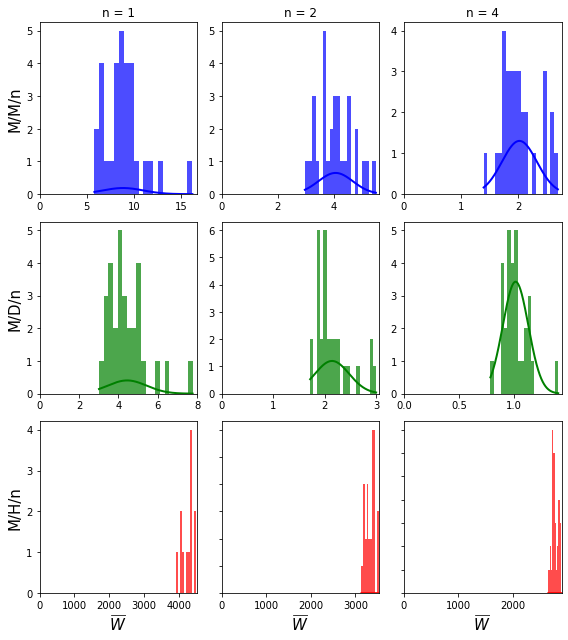

In [65]:
# Create subplots
fig, axs = plt.subplots(3, 3, figsize=(8, 9))

# First Row: mm1_09, mm2_09, mm2_099
axs[0, 0].hist(mm1_09[0][0], bins=20, density=False, alpha=0.7, color='blue')
axs[0, 0].set_title('n = 1')
axs[0, 0].plot(normal_pdf(mm1_09[0][0])[0], normal_pdf(mm1_09[0][0])[1], linewidth=2, color='blue')
axs[0, 0].set_xlim(left=0)

axs[0, 1].hist(mm2_09[0][0], bins=20, density=False, alpha=0.7, color='blue')
axs[0, 1].set_title('n = 2')
axs[0, 1].plot(normal_pdf(mm2_09[0][0])[0], normal_pdf(mm2_09[0][0])[1], linewidth=2, color='blue')
axs[0, 1].set_xlim(left=0)

axs[0, 2].hist(mm4_09[0][0], bins=20, density=False, alpha=0.7, color='blue')
axs[0, 2].set_title('n = 4')
axs[0, 2].plot(normal_pdf(mm4_09[0][0])[0], normal_pdf(mm4_09[0][0])[1], linewidth=2, color='blue')
axs[0, 2].set_xlim(left=0)

axs[1, 0].hist(md1_09[0][0], bins=20, density=False, alpha=0.7, color='green')
axs[1, 0].plot(normal_pdf(md1_09[0][0])[0], normal_pdf(md1_09[0][0])[1], linewidth=2, color='green')
axs[1, 0].set_xlim(left=0)

axs[1, 1].hist(md2_09[0][0], bins=20, density=False, alpha=0.7, color='green')
axs[1, 1].plot(normal_pdf(md2_09[0][0])[0], normal_pdf(md2_09[0][0])[1], linewidth=2, color='green')
axs[1, 1].set_xlim(left=0)

axs[1, 2].hist(md4_09[0][0], bins=20, density=False, alpha=0.7, color='green')
axs[1, 2].plot(normal_pdf(md4_09[0][0])[0], normal_pdf(md4_09[0][0])[1], linewidth=2, color='green')
axs[1, 2].set_xlim(left=0)


axs[2, 0].hist(mh1_09[0][0], bins=10, density=False, alpha=0.7, color='red')
axs[2, 0].plot(normal_pdf(mh1_09[0][0])[0], normal_pdf(mh1_09[0][0])[1], linewidth=2, color='red')
axs[2, 0].set_xlim(left=0)

axs[2, 1].hist(mh2_09[0][0], bins=10, density=False, alpha=0.7, color='red')
axs[2, 1].plot(normal_pdf(mh2_09[0][0])[0], normal_pdf(mh2_09[0][0])[1], linewidth=2, color='red')
axs[2, 1].set_xlim(left=0)

axs[2, 2].hist(mh4_09[0][0], bins=10, density=False, alpha=0.7, color='red')
axs[2, 2].plot(normal_pdf(mh4_09[0][0])[0], normal_pdf(mh4_09[0][0])[1], linewidth=2, color='red')
axs[2, 2].set_xlim(left=0)


# Customizing labels and layout
y_labels = ['M/M/n', 'M/D/n', 'M/H/n']
for i, ax in enumerate(axs[:, 0]):
    ax.set_ylabel(y_labels[i], fontsize=15)

for ax in axs[-1, :]:
    ax.set_xlabel(r'$\widebar{W}$', fontsize=15)
    ax.label_outer()

plt.tight_layout()
plt.savefig("sampling_distribution_MMn_MHn_MDn.png", dpi=300)
plt.show()


Statistics for M/D/n

In [66]:
#means for rho=0.9
mean_md1_09 = md1_09[1]
mean_md2_09 = md2_09[1]
mean_md4_09 = md4_09[1]
print(mean_md1_09, mean_md2_09, mean_md4_09)

#std dev for rho=0.9
std_md1_09 = md1_09[2]
std_md2_09 = md2_09[2]
std_md4_09 = md4_09[2]
print(std_md1_09, std_md2_09, std_md4_09)

#CI radius for rho=0.9
mdn_margin_errors = [1.96 * i / np.sqrt(num_simulations) for i in [std_md1_09, std_md2_09, std_md4_09]]
print(mdn_margin_errors)

[4.44256723] [2.14498035] [1.01648275]
[0.98694356] [0.33255863] [0.11659325]
[array([0.35317322]), array([0.11900458]), array([0.04172236])]


Statistics for M/H/n

In [67]:
#means for rho=0.9
mh1_09_without_nan = [x for x in mh1_09[0][0] if not np.isnan(x)]

mean_mh1_09 = np.mean(mh1_09_without_nan)
mean_mh2_09 = mh2_09[1]
mean_mh4_09 = mh4_09[1]
print(mean_mh1_09, mean_mh2_09, mean_mh4_09)

#std dev for rho=0.9
std_mh1_09 = np.std(mh1_09_without_nan)
std_mh2_09 = mh2_09[2]
std_mh4_09 = mh4_09[2]
print(std_mh1_09, std_mh2_09, std_mh4_09)

#CI radius for rho=0.9
mhn_margin_errors = [1.96 * i / np.sqrt(num_simulations) for i in [std_mh1_09, std_mh2_09, std_mh4_09]]
print(mhn_margin_errors)

4261.732886028636 [3343.48890289] [2782.42086296]
171.40423115898847 [103.03546631] [60.87100816]
[61.336216386970456, array([36.87076809]), array([21.78241052])]


Normality test M/D/n

In [68]:
#perform Shapiro-Wilk test for normality for rho=0.9
print(shapiro(md1_09[0][0]))
print(shapiro(md2_09[0][0]))
print(shapiro(md4_09[0][0]))

## if p<0.05 -- reject normality

ShapiroResult(statistic=0.8920278549194336, pvalue=0.0053905462846159935)
ShapiroResult(statistic=0.847551703453064, pvalue=0.0005512397619895637)
ShapiroResult(statistic=0.9078136086463928, pvalue=0.013111572712659836)


Normality test M/H/n

In [69]:
#perform Shapiro-Wilk test for normality for rho=0.9
print(shapiro(mh1_09[0][0]))
print(shapiro(mh2_09[0][0]))
print(shapiro(mh4_09[0][0]))

## if p<0.05 -- reject normality

ShapiroResult(statistic=nan, pvalue=1.0)
ShapiroResult(statistic=0.9604870080947876, pvalue=0.31876319646835327)
ShapiroResult(statistic=0.9558103680610657, pvalue=0.24119767546653748)


Tests

In [70]:
### F-test for rho=0.9

#MM1 vs MH1
f_statistic, p_value_1 = f_oneway(mm1_09[0][0], mh1_09_without_nan)
print(p_value_1)
#MM1 vs MD1
f_statistic, p_value_2 = f_oneway(mm1_09[0][0], md1_09[0][0])
print(p_value_2)
#MD1 vs MH1
f_statistic, p_value_3 = f_oneway(md1_09[0][0], mh1_09_without_nan)
print(p_value_3)

#MM2 vs MH2
f_statistic, p_value_4 = f_oneway(mm2_09[0][0], mh2_09[0][0])
print(p_value_4)
#MM2 vs MD2
f_statistic, p_value_5 = f_oneway(mm2_09[0][0], md2_09[0][0])
print(p_value_5)
#MD2 vs MH2
f_statistic, p_value_6 = f_oneway(md2_09[0][0], mh2_09[0][0])
print(p_value_6)

#MM4 vs MH4
f_statistic, p_value_7 = f_oneway(mm4_09[0][0], mh4_09[0][0])
print(p_value_7)
#MM4 vs MD4
f_statistic, p_value_8 = f_oneway(mm4_09[0][0], md4_09[0][0])
print(p_value_8)
#MD4 vs MH4
f_statistic, p_value_9 = f_oneway(md4_09[0][0], mh4_09[0][0])
print(p_value_9)


1.6532238885354526e-54
2.615505201367954e-14
1.5768323525261506e-54
1.274418052081486e-80
3.2931384616920857e-21
1.2320463701410255e-80
2.980072509955354e-89
1.7315241832974924e-23
2.916765459503041e-89


In [71]:
#### Welch's t-test for rho=0.9

#MM1 vs MH1
print(stats.ttest_ind(mm1_09[0][0], mh1_09_without_nan, equal_var = False))
#MM1 vs MD1
print(stats.ttest_ind(mm1_09[0][0], md1_09[0][0], equal_var = False))
#MD1 vs MH1
print(stats.ttest_ind(md1_09[0][0], mh1_09_without_nan, equal_var = False))


#MM2 vs MH2
print(stats.ttest_ind(mm2_09[0][0], mh2_09[0][0], equal_var = False))
#MM2 vs MD2
print(stats.ttest_ind(mm2_09[0][0], md2_09[0][0], equal_var = False))
#MD2 vs MH2
print(stats.ttest_ind(md2_09[0][0], mh2_09[0][0], equal_var = False))

#MM4 vs MH4
print(stats.ttest_ind(mm4_09[0][0], mh4_09[0][0], equal_var = False))
#MM4 vs MD4
print(stats.ttest_ind(mm4_09[0][0], md4_09[0][0], equal_var = False))
#MD4 vs MH4
print(stats.ttest_ind(md4_09[0][0], mh4_09[0][0], equal_var = False))

Ttest_indResult(statistic=-82.28997039764383, pvalue=1.059492424203483e-16)
Ttest_indResult(statistic=10.046246103190589, pvalue=1.3448683113623273e-12)
Ttest_indResult(statistic=-82.37688026832421, pvalue=1.0502322084176371e-16)
Ttest_indResult(statistic=-174.53298424229172, pvalue=2.2326913504394676e-45)
Ttest_indResult(statistic=14.693339118151618, pvalue=1.0498097090668882e-18)
Ttest_indResult(statistic=-174.6349545559922, pvalue=2.204886197682615e-45)
Ttest_indResult(statistic=-245.97496583845071, pvalue=1.0736949537082615e-49)
Ttest_indResult(statistic=16.431447176593338, pvalue=1.2016219210779033e-18)
Ttest_indResult(statistic=-246.06613164627132, pvalue=1.0666912233793013e-49)
